# Data for Section 4.3: Hospitalization Nowcasting

In [1]:
library(here)
source(here("setup.R"))


here() starts at /Users/stefan/workspace/work/phd/thesis



In [2]:
hospitalisations_raw <- read_csv(here("data/raw/all_hosp_age.csv")) %>%
    select(-location) %>%
    rename(a = age_group, s = case_date, t = hosp_date, H = value)

rki_raw <- read_csv(here("data/raw/delayed_cases_age.csv"))


In [3]:
# helper to summarize over age groups
sum_age_groups <- function(df, age_column = "a", value_column = "h", all_age_value = "00+") {
    df %>%
        group_by(across(-c(!!age_column, !!value_column))) %>%
        summarize(!!value_column := sum(!!rlang::sym(value_column))) %>%
        mutate(!!age_column := "00+") %>%
        select(-!!age_column, -!!value_column, !!age_column, !!value_column)
}

add_all_age_groups <- function(df, age_column = "a", value_column = "h", all_age_value = "00+") {
    df %>%
        rbind(sum_age_groups(df, age_column, value_column, all_age_value))
}


In [5]:
hospitalisations_raw


t,s,a,H
<date>,<date>,<chr>,<dbl>
2021-04-06,2020-03-04,00-04,0
2021-04-06,2020-03-04,05-14,0
2021-04-06,2020-03-04,15-34,17
2021-04-06,2020-03-04,35-59,34
2021-04-06,2020-03-04,60-79,12
2021-04-06,2020-03-04,80+,1
2021-04-06,2020-03-05,00-04,0
2021-04-06,2020-03-05,05-14,0
2021-04-06,2020-03-05,15-34,17


s,a,k,h
<date>,<chr>,<dbl>,<dbl>
2021-04-05,00-04,0,65
2021-04-05,05-14,0,73
2021-04-05,15-34,0,331
2021-04-05,35-59,0,839
2021-04-05,60-79,0,1160
2021-04-05,80+,0,778


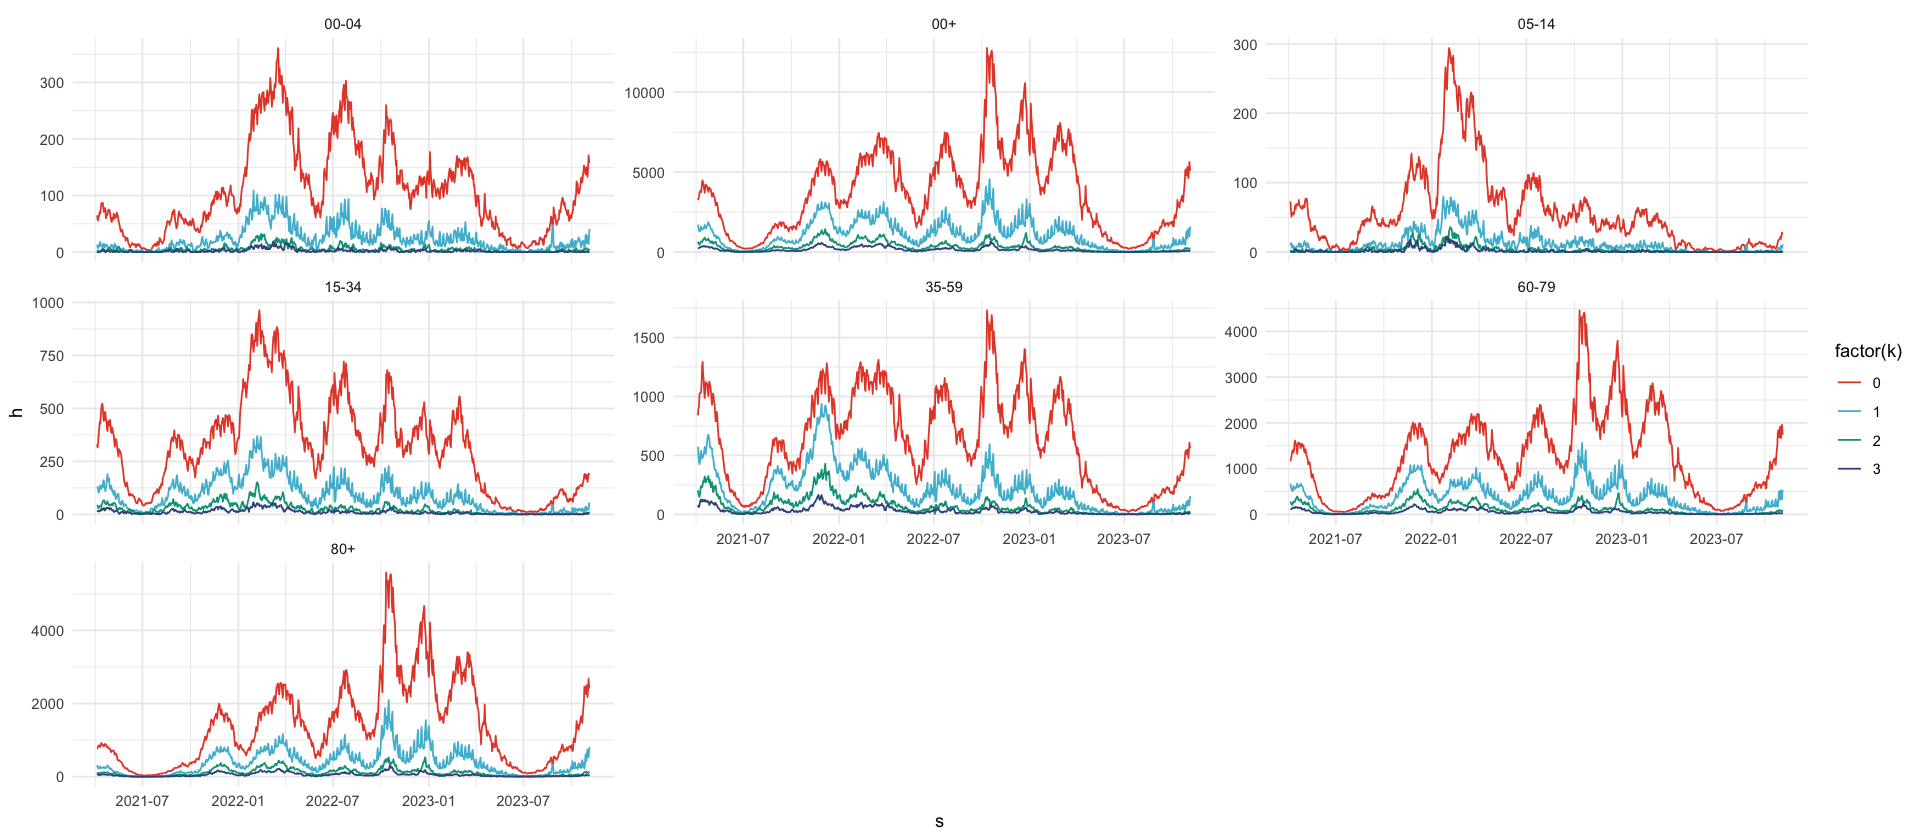

In [6]:
reporting_triangle_processed <- hospitalisations_raw %>%
    mutate(delay = as.numeric(t - s)) %>%
    # d = 0 is known, chunk remainder into weekly units
    mutate(k = (delay + 5) %/% 7) %>%
    group_by(s, a, k) %>%
    summarize(H = max(H)) %>%
    filter(k < 8) %>%
    arrange(s, k) %>%
    group_by(s) %>%
    # only those dates where all k are available
    filter(min(k) == 0, max(k) >= 7) %>%
    ungroup() %>%
    group_by(s, a) %>%
    arrange(k) %>%
    # ensure positive increments, treat last H as truth
    mutate(h = diff(c(0, pmin(cummax(H), tail(H, 1))))) %>%
    ungroup() %>%
    arrange(s, k) %>%
    select(s, a, k, h) %>%
    add_all_age_groups()

reporting_triangle_processed %>%
    head()

reporting_triangle_processed %>%
    filter(k <= 3) %>%
    ggplot(aes(s, h, color = factor(k))) +
    geom_line() +
    facet_wrap(~a, scale = "free_y")


In [7]:
reporting_triangle_processed %>%
    filter(h < 0)
stopifnot(all(reporting_triangle_processed$h >= 0))


s,a,k,h
<date>,<chr>,<dbl>,<dbl>


a,s,I
<chr>,<date>,<dbl>
00-04,2020-04-10,248
00-04,2020-04-11,225
00-04,2020-04-12,219
00-04,2020-04-13,214
00-04,2020-04-14,206
00-04,2020-04-15,165


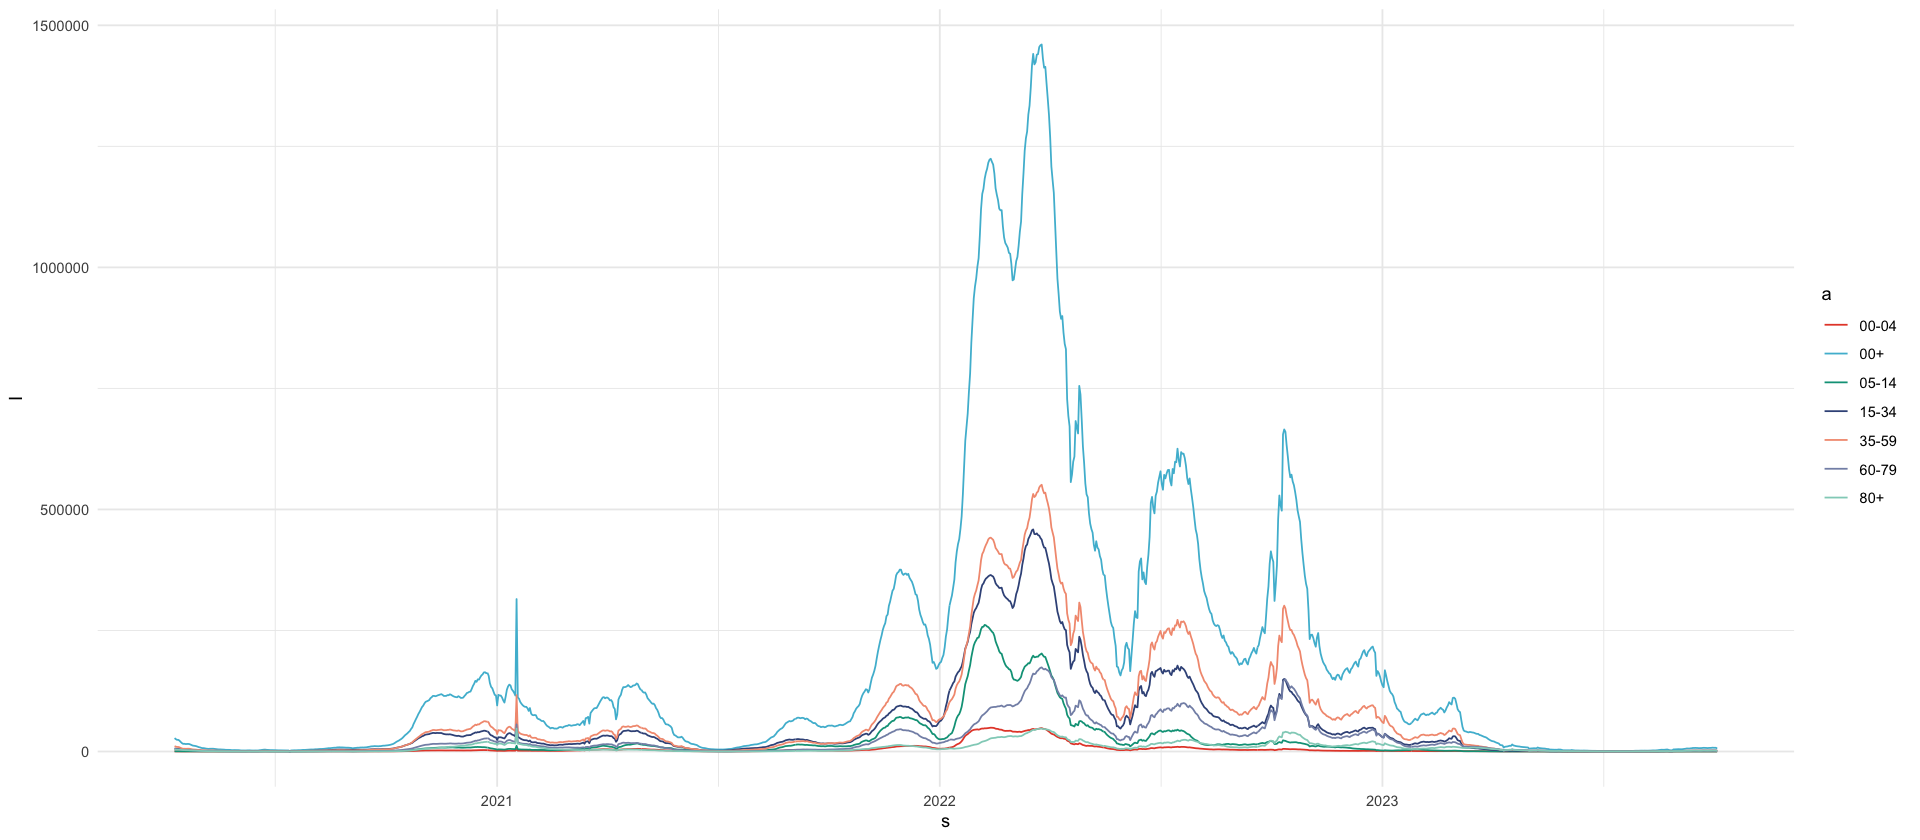

In [8]:
seven_day_incidence_frozen <- rki_raw %>%
    filter(age_group != "unbekannt") %>%
    mutate(age_group = str_replace_all(age_group, "A", "")) %>%
    # watch out here, aggregate seven day I by rki date, not county date?
    mutate(delay = rki_date - county_date) %>%
    group_by(age_group, rki_date) %>%
    filter(delay <= 7) %>%
    summarize(cases = sum(cases)) %>%
    rename(a = age_group, s = rki_date, I = cases) %>%
    add_all_age_groups(value_column = "I")

seven_day_incidence_frozen %>%
    head()

seven_day_incidence_frozen %>%
    ggplot(aes(s, I, color = a)) +
    geom_line()


In [9]:
full_df <- reporting_triangle_processed %>%
    inner_join(seven_day_incidence_frozen)

full_df %>%
    write_csv(here("data/processed/seven_day_H_I_by_age.csv"))

full_df %>%
    head()


Joining with `by = join_by(s, a)`


s,a,k,h,I
<date>,<chr>,<dbl>,<dbl>,<dbl>
2021-04-05,00-04,0,65,4348
2021-04-05,05-14,0,73,9740
2021-04-05,15-34,0,331,31851
2021-04-05,35-59,0,839,41889
2021-04-05,60-79,0,1160,14813
2021-04-05,80+,0,778,3617
